# Multi-Class Classification: Predicting Marijuana Use Frequency


In [2]:
# Data Loading
import pandas as pd
df = pd.read_csv('../data/processed_data.csv')


## Data Cleaning & Preprocessing
- Use IRMJFY (Imputation-revised marijuana frequency, past year) as the target.
- Per codebook:
    - 991: Never used marijuana
    - 994/997/998/999: Missing, refused, blank, skip (set to NaN)
- Target categories:
    - 0: Never (IRMJFY == 991)
    - 1: Seldom (IRMJFY in 1–11)
    - 2: Sometimes (IRMJFY in 12–49)
    - 3: Frequent (IRMJFY >= 50)
- Drop rows with ambiguous/missing codes.


In [3]:
# Rename columns for clarity
df = df.rename(columns={
    'IRMJFY': 'Marijuana_Use_Frequency',
    'PARHLPHW': 'Parental_Support',
    'SCHFELT': 'School_Safety',
    'INCOME': 'Income_Level',
    'FRDMEVR2': 'Peer_Use_Ever',
    'FRDMJMON': 'Peer_Use_Month',
    'YOGRPFT2': 'Risk_Behavior',
    'HEALTH2': 'Health_Status'
})

# Set ambiguous/missing codes to NaN
df['Marijuana_Use_Frequency'] = df['Marijuana_Use_Frequency'].replace([994, 997, 998, 999], pd.NA)

# Create multi-class target
def mj_freq_category(val):
    if pd.isna(val):
        return pd.NA
    if val == 991:
        return 0  # Never
    if 1 <= val <= 11:
        return 1  # Seldom
    if 12 <= val <= 49:
        return 2  # Sometimes
    if val >= 50:
        return 3  # Frequent
    return pd.NA

df['MJ_Freq_Class'] = df['Marijuana_Use_Frequency'].apply(mj_freq_category)
df = df[df['MJ_Freq_Class'].notna()]

print("Class distribution:\n", df['MJ_Freq_Class'].value_counts())


Class distribution:
 MJ_Freq_Class
0    8895
3     810
1     456
2     308
Name: count, dtype: int64


## Feature Engineering
- Impute missing values for features with mean.
- Create interaction terms:
    - School_Parental_Interaction = Parental_Support × School_Safety
    - Peer_Influence = Peer_Use_Ever × Peer_Use_Month


In [4]:
for col in ['Parental_Support', 'School_Safety', 'Income_Level', 'Peer_Use_Ever', 'Peer_Use_Month', 'Risk_Behavior', 'Health_Status']:
    df[col] = df[col].fillna(df[col].mean())

df['School_Parental_Interaction'] = df['Parental_Support'] * df['School_Safety']
df['Peer_Influence'] = df['Peer_Use_Ever'] * df['Peer_Use_Month']

features = [
    'Parental_Support', 'School_Safety', 'Income_Level',
    'School_Parental_Interaction', 'Peer_Influence',
    'Risk_Behavior', 'Health_Status'
]
X = df[features]
y = df['MJ_Freq_Class']


## Exploratory Data Analysis
- Visualize class distribution and feature relationships.


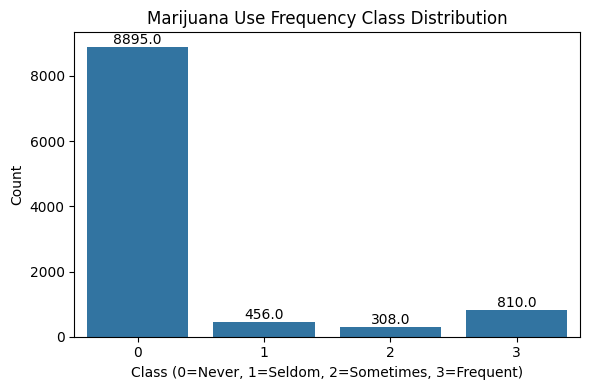

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=y)
plt.title('Marijuana Use Frequency Class Distribution')
plt.xlabel('Class (0=Never, 1=Seldom, 2=Sometimes, 3=Frequent)')
plt.ylabel('Count')

for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            height + 5,  # adjust vertical position if needed
            f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Handling Class Imbalance (SMOTE)
- SMOTE is applied to the training set to synthesize minority classes and balance the dataset.


In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:", y_train_res.value_counts().to_dict())


Resampled class distribution: {0: 7116, 1: 7116, 3: 7116, 2: 7116}


## Modeling

### Decision Tree
- **Rationale**: Interpretable baseline for multi-class classification.
- **Hyperparameters**: max_depth=5, min_samples_leaf=10, class_weight='balanced'


In [7]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(
    max_depth=5, min_samples_leaf=10, class_weight='balanced', random_state=42
)
dt_clf.fit(X_train_res, y_train_res)


DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=10, random_state=42)

Decision Tree Info:
Total Nodes in Tree: 63
Total Leaves in Tree: 32
Max Depth of Tree: 5


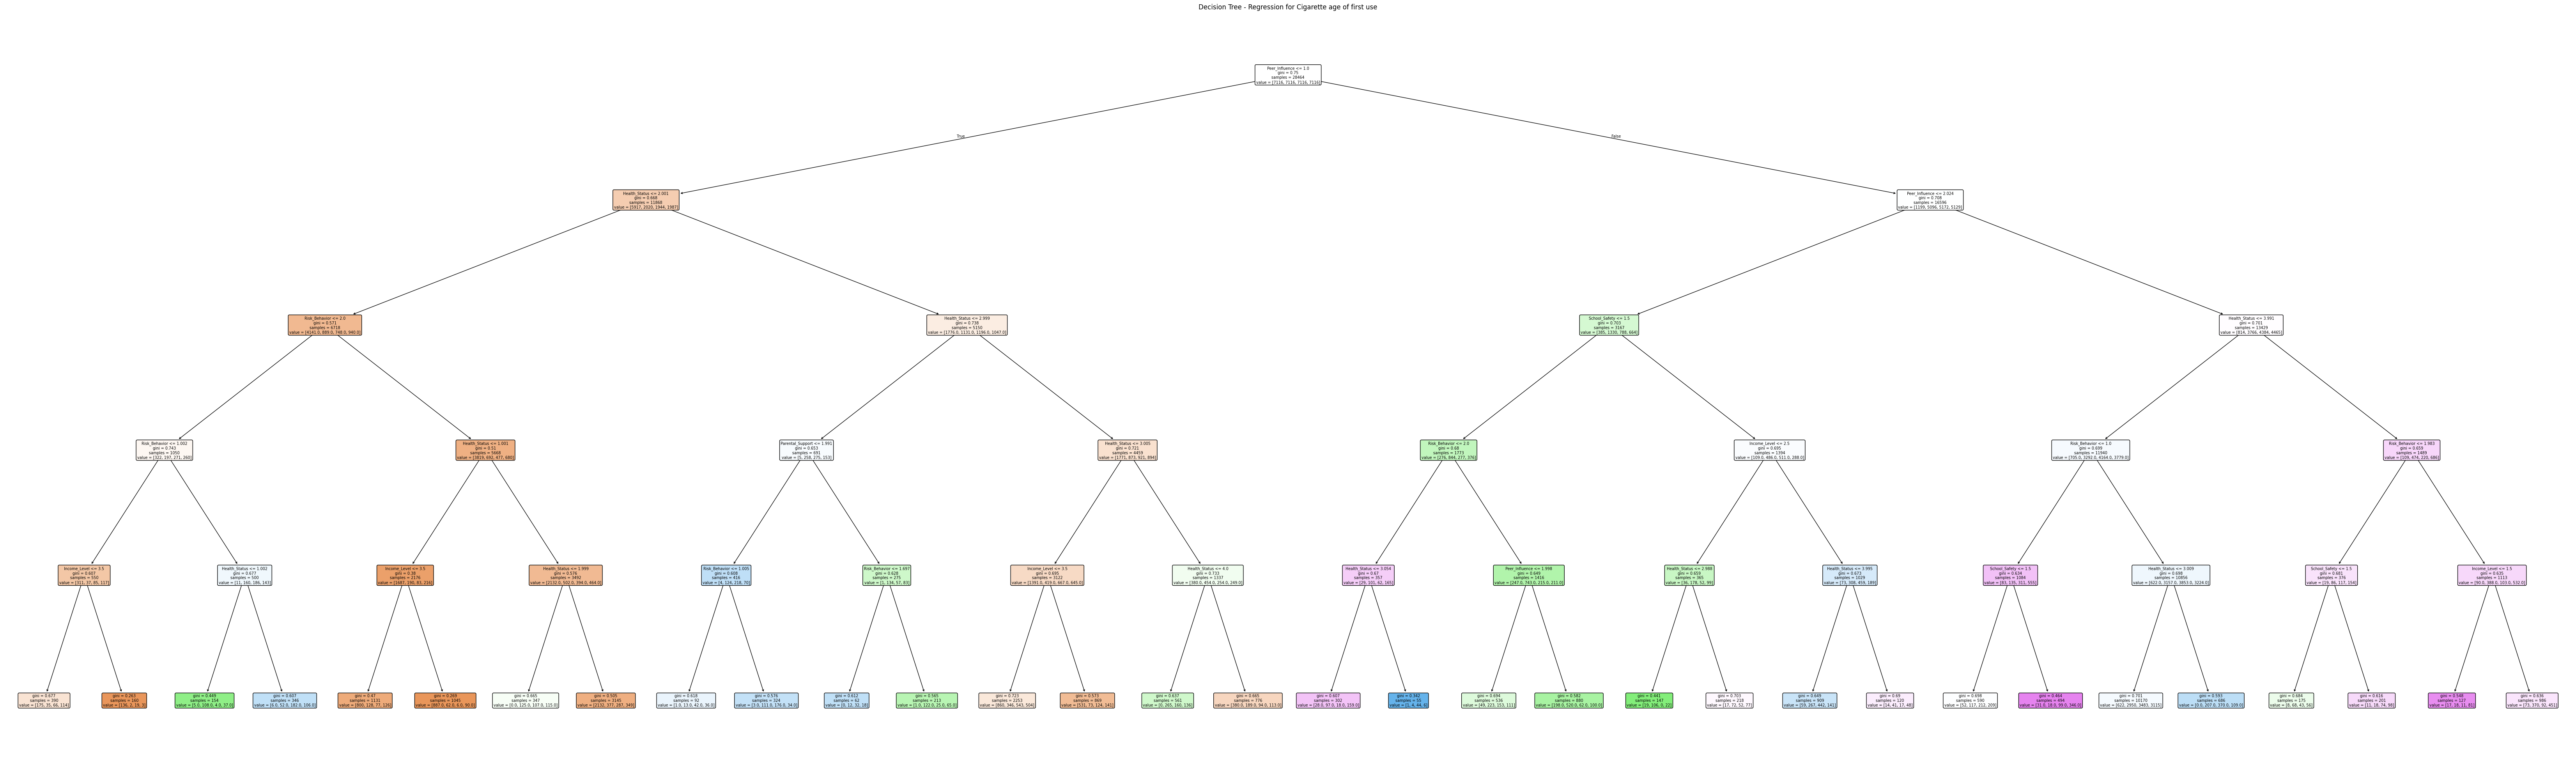

In [8]:
from sklearn.tree import plot_tree

# Print Decision Tree structure info
print("Decision Tree Info:")
print(f"Total Nodes in Tree: {dt_clf.tree_.node_count}")
print(f"Total Leaves in Tree: {dt_clf.get_n_leaves()}")
print(f"Max Depth of Tree: {dt_clf.tree_.max_depth}")
plt.figure(figsize=(85, 25))
plot_tree(dt_clf, feature_names=X.columns, filled=True, rounded=True)
plt.title("Decision Tree - Regression for Cigarette age of first use")
plt.savefig("../results/decision_tree_structure.png")
plt.show()
plt.close()


### Bagging (Bootstrap Aggregating)
- **Rationale**: Reduces variance by averaging predictions from multiple decision trees trained on bootstrapped samples.
- **Hyperparameters**: n_estimators=50, base_estimator=DecisionTreeClassifier


In [9]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=5, min_samples_leaf=10, class_weight='balanced', random_state=42
    ),
    n_estimators=50,
    random_state=42
)
bag_clf.fit(X_train_res, y_train_res)


BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_depth=5,
                                                   min_samples_leaf=10,
                                                   random_state=42),
                  n_estimators=50, random_state=42)

### Random Forest
- **Rationale**: Adds feature randomness to bagging, improving robustness and generalization.
- **Hyperparameters**: n_estimators=100, max_depth=5, class_weight='balanced'


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100, max_depth=5, class_weight='balanced', random_state=42
)
rf_clf.fit(X_train_res, y_train_res)


RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

### Gradient Boosting
- **Rationale**: Sequentially fits trees to correct previous errors, often improving accuracy.
- **Hyperparameters**: n_estimators=100, learning_rate=0.1, max_depth=3


In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
)
gb_clf.fit(X_train_res, y_train_res)


GradientBoostingClassifier(random_state=42)

## Model Evaluation & Comparison
- Metrics: Accuracy, Macro F1, Weighted F1, Confusion Matrix


Confusion Matrix for Decision_Tree
[[1450   68  205   56]
 [  36    9   38    8]
 [  21    1   28   12]
 [  48   10   64   40]]


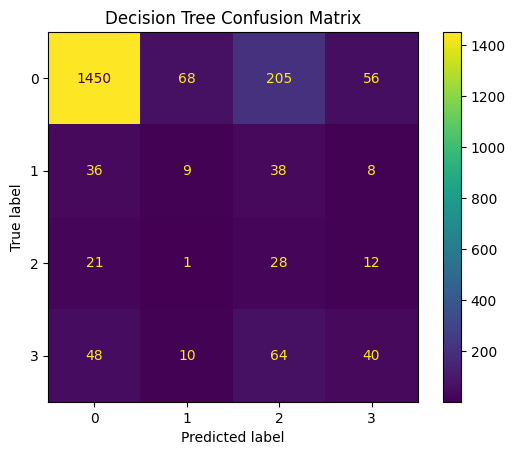

Confusion Matrix for Bagging
[[1449   71  199   60]
 [  36    9   37    9]
 [  21    3   25   13]
 [  48    9   62   43]]


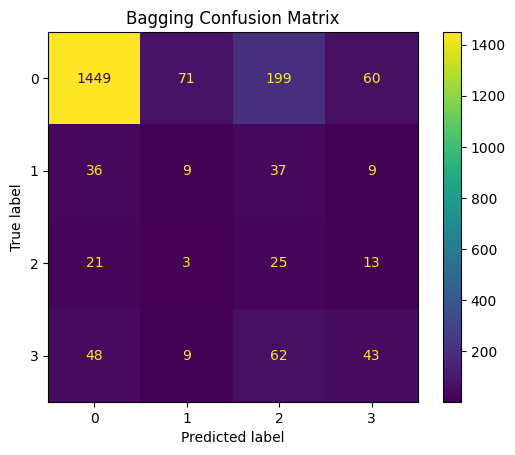

Confusion Matrix for Random_Forest
[[1423  125  113  118]
 [  32   15   23   21]
 [  17   11    9   25]
 [  45   30   30   57]]


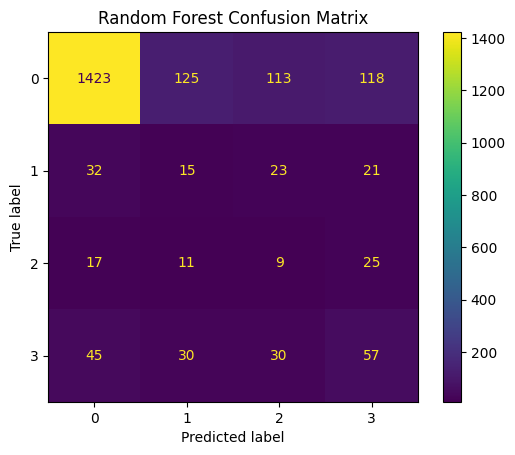

Confusion Matrix for Gradient_Boosting
[[1461  134   46  138]
 [  33   19   14   25]
 [  22    7    6   27]
 [  50   25   15   72]]


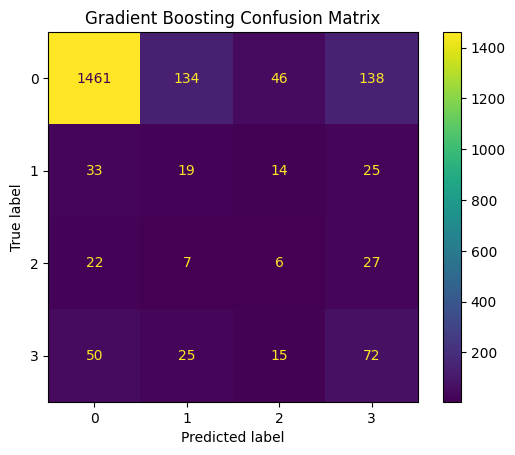


Model Performance Comparison:
               Model  Accuracy  Macro F1  Weighted F1
0      Decision Tree  0.729226  0.349803     0.769788
1            Bagging  0.728749  0.349342     0.769992
2      Random Forest  0.718243  0.336841     0.763648
3  Gradient Boosting  0.744031  0.358691     0.776878


In [12]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

models = {
    'Decision Tree': dt_clf,
    'Bagging': bag_clf,
    'Random Forest': rf_clf,
    'Gradient Boosting': gb_clf
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Macro F1': f1_score(y_test, y_pred, average='macro'),
        'Weighted F1': f1_score(y_test, y_pred, average='weighted')
    })
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    disp.ax_.set_title(f"{name} Confusion Matrix")
    print(f"Confusion Matrix for {name.replace(' ', '_')}")
    print(disp.confusion_matrix)
    
    plt.savefig(f"../results/{name.replace(' ', '_')}_multi_class_confusion_matrix.png")
    plt.show()
    plt.close()

results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)


## Feature Importance (Random Forest)


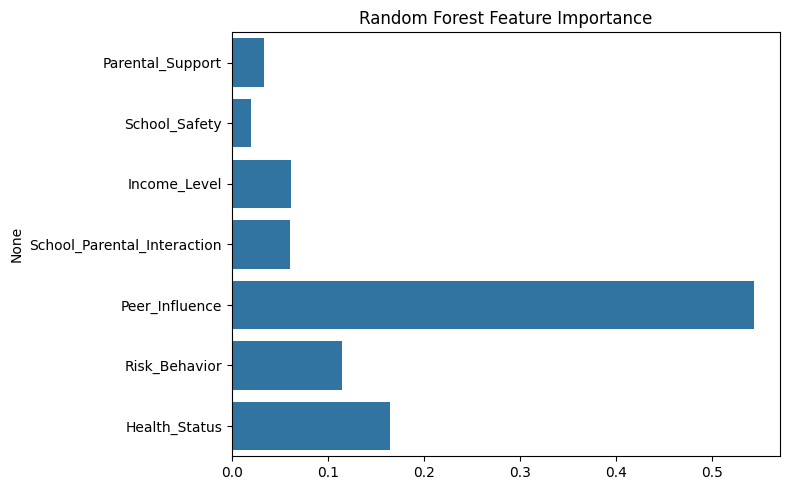

In [13]:
importances = rf_clf.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=X.columns)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig("../results/multi_class_feature_importance.png")
plt.show()
plt.close()


## Model Performance Comparison

| Model             | Accuracy | Macro F1 | Weighted F1 |
|-------------------|----------|----------|-------------|
| Decision Tree     | 0.729    | 0.350    | 0.770       |
| Bagging           | 0.729    | 0.349    | 0.770       |
| Random Forest     | 0.718    | 0.337    | 0.764       |
| Gradient Boosting | 0.744    | 0.359    | 0.777       |

**Interpretation & Key Insights:**

- **Gradient Boosting** achieved the highest overall accuracy (74.4%) and macro F1 (0.359), indicating it best balances performance across all marijuana use frequency classes.
- **Decision Tree** and **Bagging** performed nearly identically, suggesting that bagging did not significantly improve over a single tree for this task.
- **Random Forest** had slightly lower accuracy and macro F1, but all ensemble methods provided robust results.
- **Weighted F1** scores are high for all models, reflecting strong performance on the majority class ("Never"), but macro F1 scores show that performance on minority classes (e.g., "Frequent") is more modest.

**Feature Importance (Random Forest):**

- **Peer Influence** is by far the most important predictor, accounting for over 50% of the model's importance. This aligns with the project PDF and codebook, which highlight peer substance use as a key risk factor for youth marijuana use.
- **Health Status** and **Risk Behavior** are also substantial contributors, indicating that students with poorer health or more risk-taking behaviors are more likely to use marijuana frequently.
- **Parental Support** and **School Safety** have lesser but still meaningful importance, suggesting that family and school environments play a secondary but non-negligible role.

**Takeaways:**

- **Peer influence** is the dominant factor in predicting marijuana use frequency among youth, confirming established findings in substance use research.
- **Ensemble methods** (especially Gradient Boosting) slightly improve predictive performance, but the overall pattern of feature importance remains consistent.
- **Interventions** targeting peer networks and risk behaviors may be most effective for reducing frequent marijuana use, while family and school-based supports remain important for prevention.

**Limitations:**

- The models may be biased toward the majority class ("Never"), as reflected by higher weighted F1 than macro F1.
- Self-reported data and limited feature scope may constrain the models' predictive power.

**Conclusion:**

- Peer influence, health status, and risk behaviors are the strongest predictors of marijuana use frequency.
- Ensemble models, particularly Gradient Boosting, offer the best balance across all classes.
- Policy and prevention efforts should focus on peer and risk behavior interventions, supported by family and school engagement.
